# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [5]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')

# Download the files
download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')

Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl


In [6]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [7]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

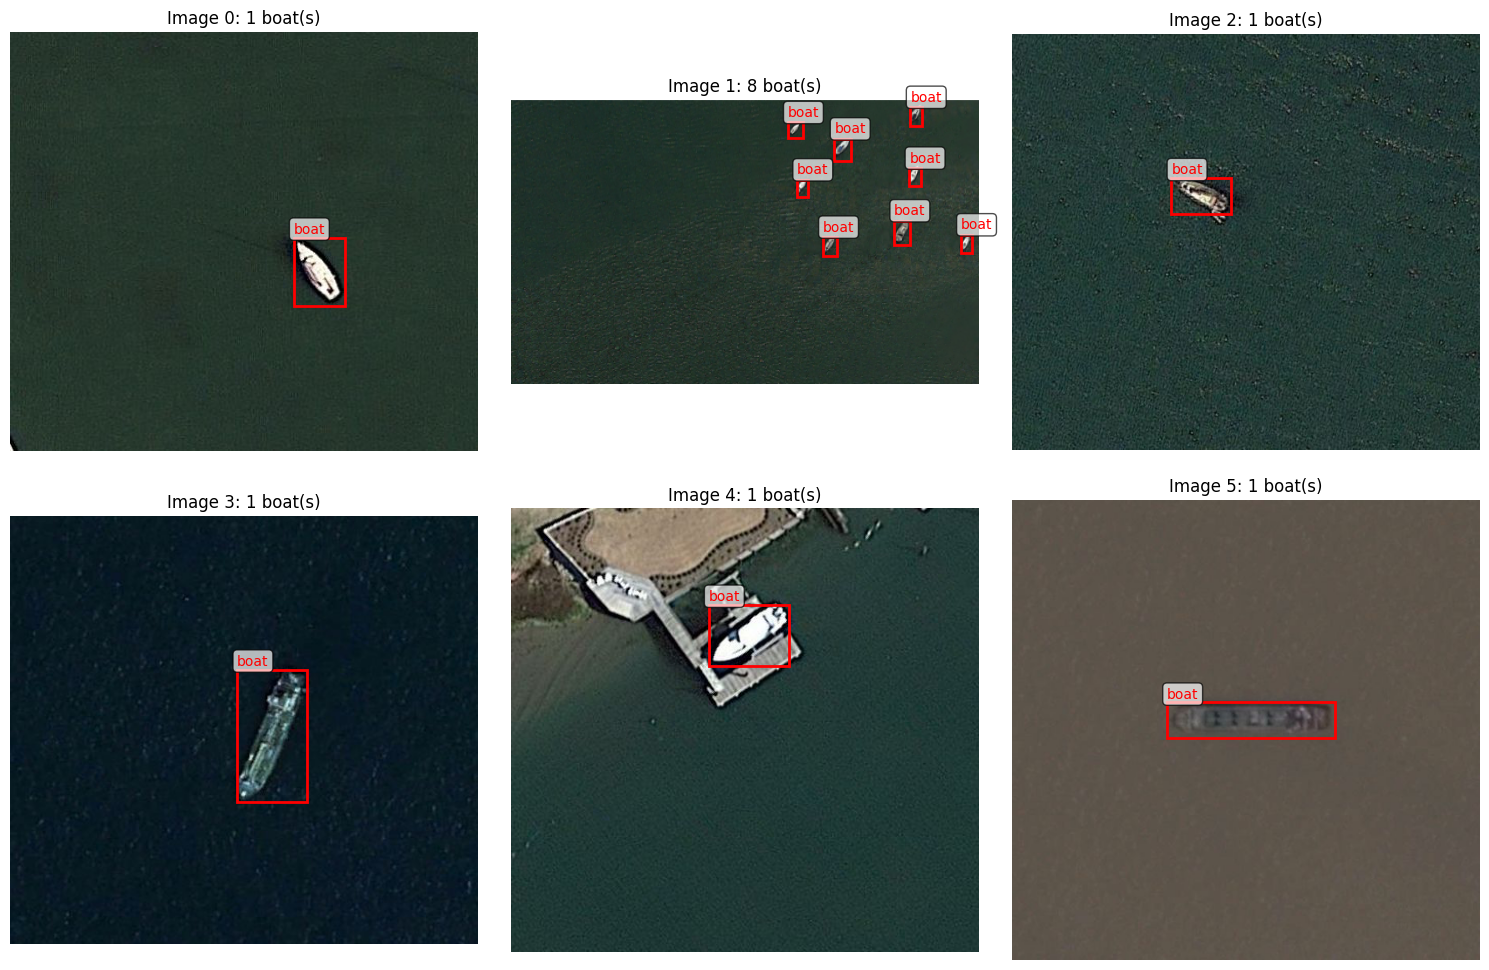

In [8]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [9]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/azelout/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded successfully!


In [10]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 /home/azelout/Bureau/Erwan/module7/temp_sample.png: 576x640 1 tennis racket, 24.6ms
Speed: 0.8ms preprocess, 24.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


In [11]:
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

def to_rgb_uint8(img, bg="black"):
    """
    Assure 3 canaux uint8.
    - Grayscale -> RGB
    - RGBA -> RGB (composite sur fond bg si besoin)
    """
    # PIL -> numpy
    if hasattr(img, "mode"):
        if img.mode in ("RGBA", "LA"):
            if bg == "white":
                # composite sur fond blanc
                bg_img = Image.new("RGB", img.size, (255, 255, 255))
                img = Image.alpha_composite(bg_img, img.convert("RGBA")).convert("RGB")
            else:
                img = img.convert("RGB")
        elif img.mode == "L":
            img = img.convert("RGB")
        else:
            img = img.convert("RGB")
        img = np.array(img)

    # numpy
    if isinstance(img, np.ndarray):
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)         # 1 -> 3
        elif img.ndim == 3 and img.shape[2] == 4:
            # RGBA -> BGR : on jette l'alpha (ou composite si tu veux garder l’apparence)
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        elif img.ndim == 3 and img.shape[2] == 3:
            pass
        else:
            raise ValueError(f"Shape inattendue: {getattr(img,'shape',None)}")

        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
    else:
        raise TypeError("Image inconnue, ni PIL ni numpy")

    return img

# 1) Normalisation
X3 = [to_rgb_uint8(img) for img in X]

# (optionnel) vérification
# print({img.shape for img in X3})

# 2) Modèle
model = YOLO("yolov8n.pt")

# 3) Inférence image par image (pas d'empilement fragile)
results = [model(img, conf=0.5)[0] for img in X3]


0: 576x640 1 tennis racket, 14.8ms
Speed: 0.9ms preprocess, 14.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 416x640 2 birds, 19.7ms
Speed: 0.6ms preprocess, 19.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 (no detections), 14.1ms
Speed: 0.9ms preprocess, 14.1ms inference, 0.2ms postprocess per image at shape (1, 3, 576, 640)

0: 608x640 (no detections), 22.7ms
Speed: 1.0ms preprocess, 22.7ms inference, 0.2ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 (no detections), 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 0.2ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 (no detections), 23.1ms
Speed: 1.1ms preprocess, 23.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.2ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 (no detections), 14.4ms
Speed: 0.9ms preprocess, 14.4ms inference

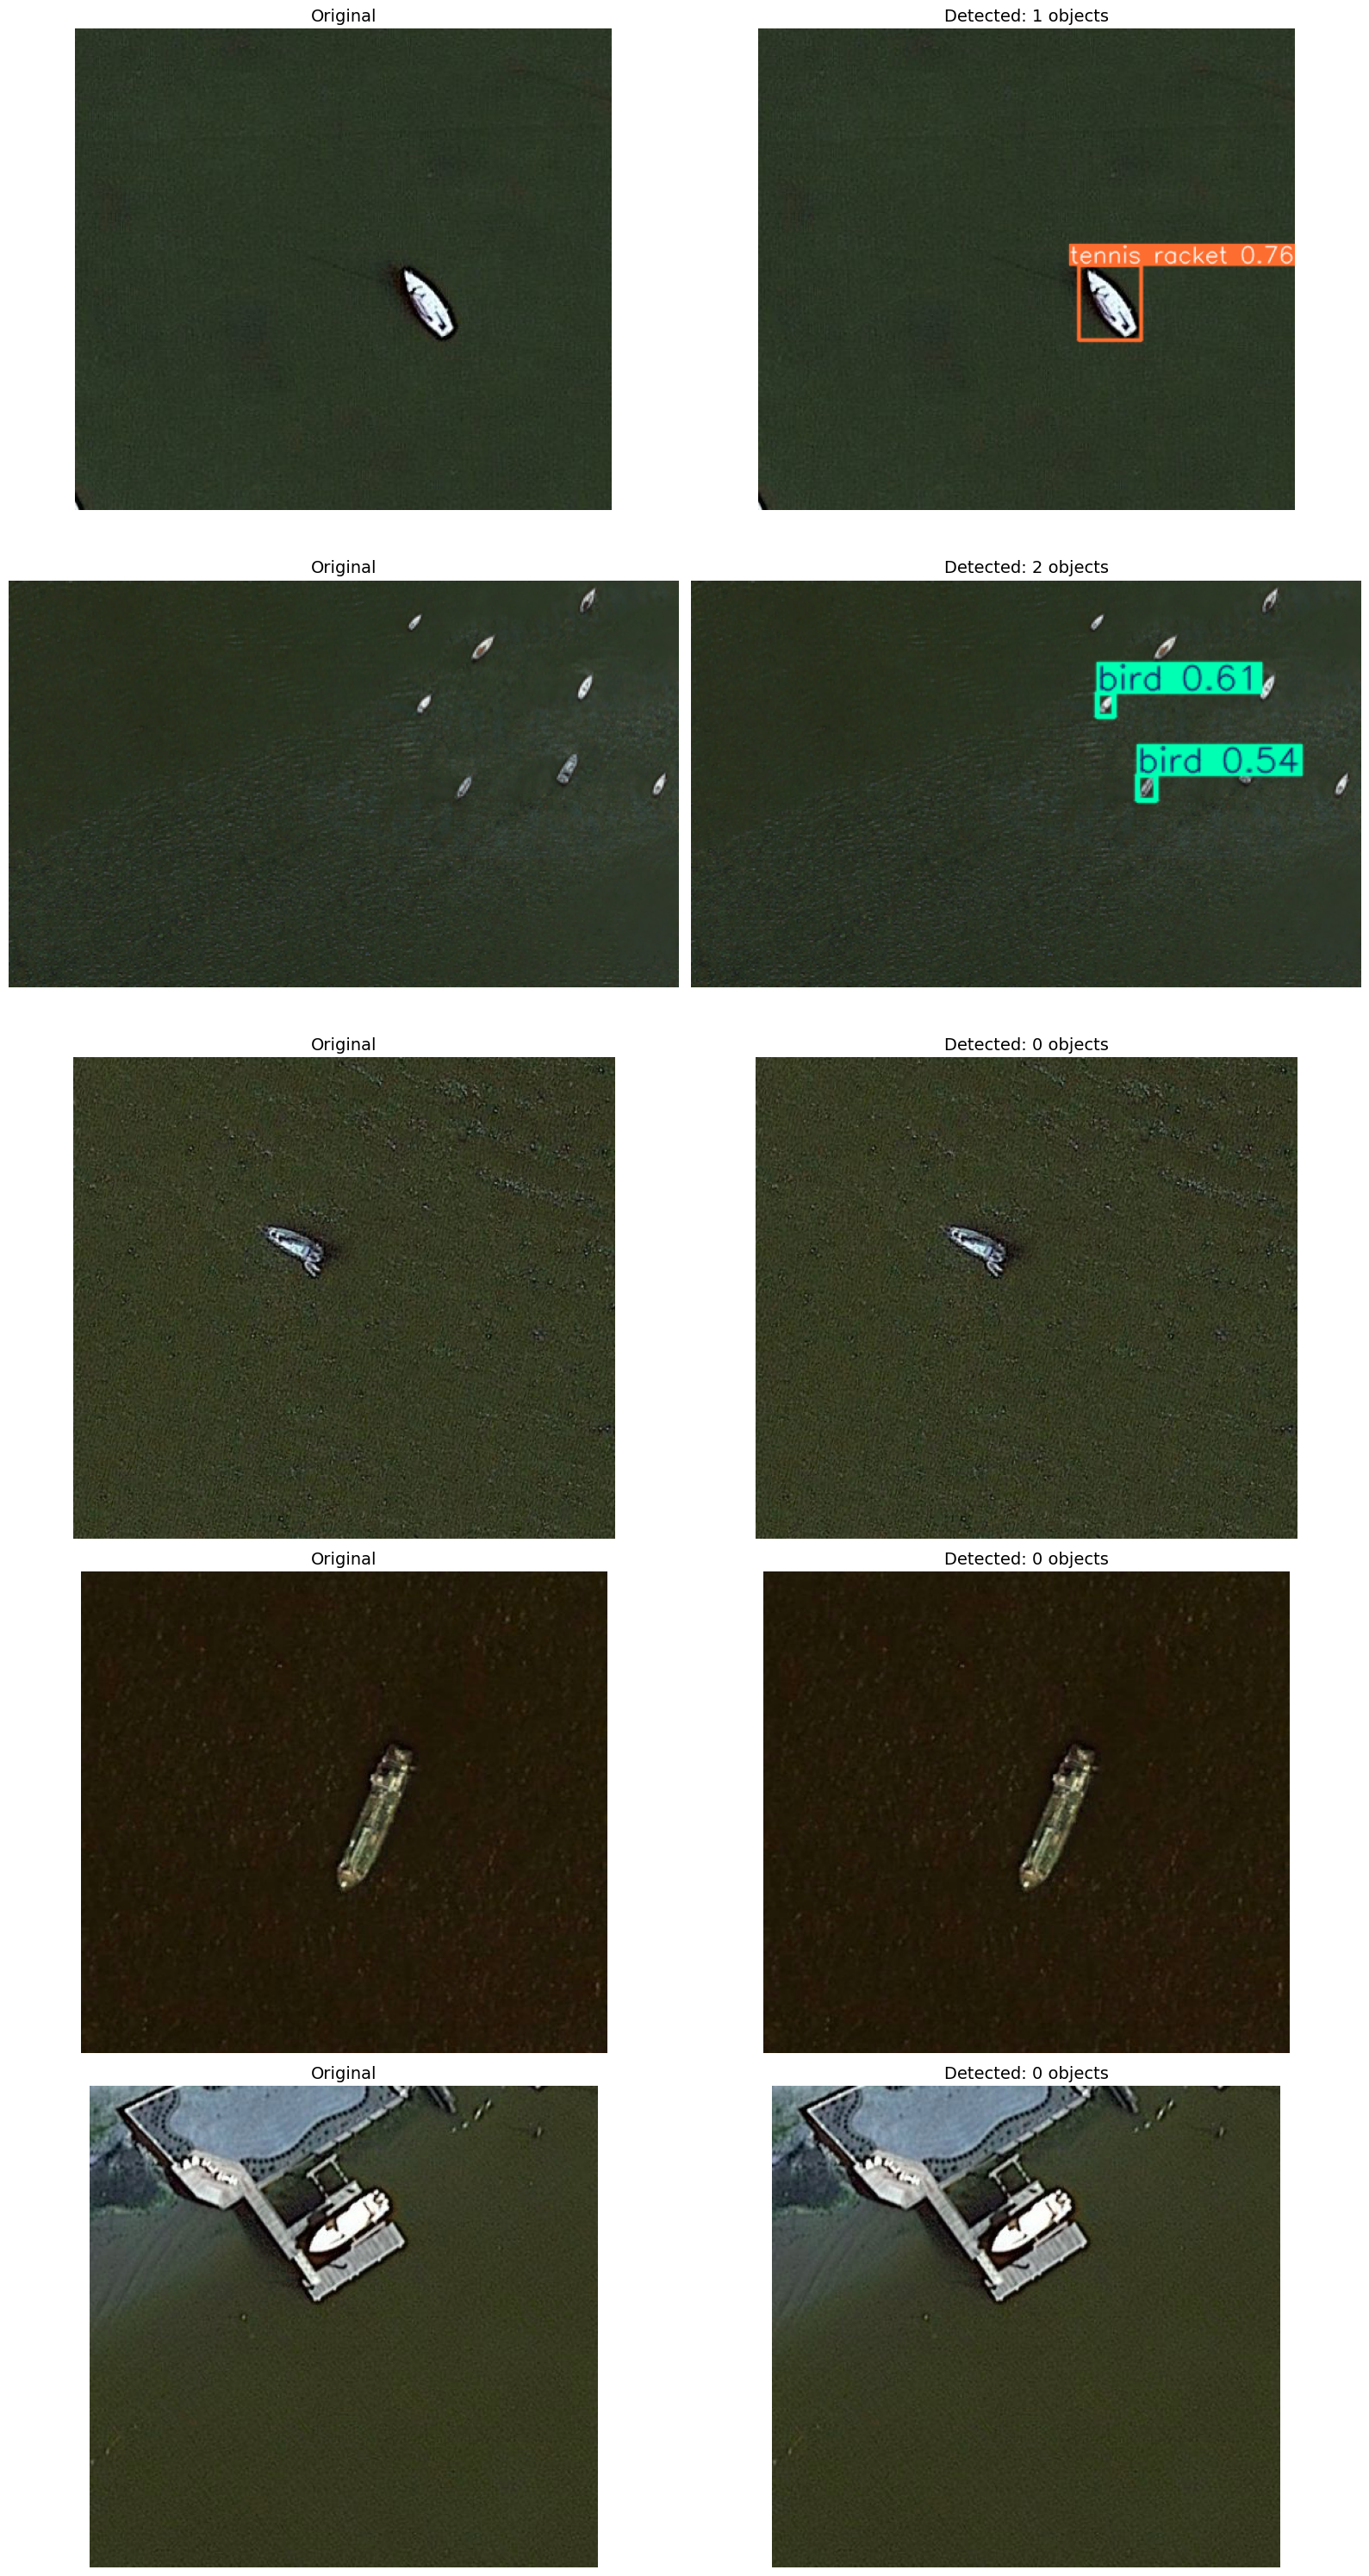

In [12]:

# Limite à 5 images pour l'affichage
n_show = 5
fig, axes = plt.subplots(n_show, 2, figsize=(16, 6*n_show))

for idx in range(n_show):
    result = results[idx]
    img = X3[idx]

    # Image originale
    axes[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[idx, 0].set_title('Original', fontsize=14)
    axes[idx, 0].axis('off')

    # Image détectée
    det = result.plot()
    axes[idx, 1].imshow(cv2.cvtColor(det, cv2.COLOR_BGR2RGB))
    axes[idx, 1].set_title(f'Detected: {len(result.boxes)} objects', fontsize=14)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()


Là on se rend compte que c'est pas ouf sans finetuning

## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import yaml
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
from ultralytics import YOLO


# 2) Fonctions utilitaires

def to_3ch_uint8(img):
    """Convertit PIL/numpy en image numpy BGR uint8 à 3 canaux."""
    if isinstance(img, Image.Image):
        img = img.convert("RGB")
        img = np.array(img)[:, :, ::-1]  # RGB -> BGR
    elif isinstance(img, np.ndarray):
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.ndim == 3 and img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        elif img.ndim == 3 and img.shape[2] == 3:
            pass
        else:
            raise ValueError(f"Image shape inattendue: {getattr(img,'shape',None)}")
    else:
        raise TypeError("Chaque élément de X doit être PIL.Image ou numpy.ndarray")

    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def write_yolo_txt(txt_path: Path, boxes: np.ndarray):
    """Écrit un fichier .txt au format YOLO."""
    txt_path.parent.mkdir(parents=True, exist_ok=True)
    lines = []
    if boxes is not None and len(boxes) > 0:
        for cls, xc, yc, w, h in np.asarray(boxes, dtype=float):
            lines.append(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
    txt_path.write_text("\n".join(lines))



# 3) Export du dataset sur disque (PARALLÉLISÉ)

def export_dataset(X, y, root="boats_dataset", train_ratio=0.8, max_threads=None):
    root = Path(root)
    img_train = root/"images"/"train"
    img_val   = root/"images"/"val"
    lab_train = root/"labels"/"train"
    lab_val   = root/"labels"/"val"
    for d in [img_train, img_val, lab_train, lab_val]:
        d.mkdir(parents=True, exist_ok=True)

    N = len(X)
    idxs = list(range(N))
    random.shuffle(idxs)
    split = int(train_ratio * N)
    train_idx, val_idx = idxs[:split], idxs[split:]

    def _save_one(i, dimg, dlab):
        img = to_3ch_uint8(X[i])
        fname = f"img_{i:06d}.jpg"
        cv2.imwrite(str(dimg / fname), img)
        boxes = y[i] if y[i] is not None else np.zeros((0,5), dtype=float)
        write_yolo_txt(dlab / fname.replace(".jpg", ".txt"), boxes)
        return fname

    if max_threads is None:
        max_threads = min(32, (os.cpu_count() or 8))

    with ThreadPoolExecutor(max_workers=max_threads) as ex:
        futs = []
        for i in train_idx:
            futs.append(ex.submit(_save_one, i, img_train, lab_train))
        for i in val_idx:
            futs.append(ex.submit(_save_one, i, img_val, lab_val))
        for _ in as_completed(futs):
            pass

    # YAML YOLO
    data_yaml = {
        "path": str(root.resolve()),
        "train": "images/train",
        "val": "images/val",
        "names": {0: "boat"}
    }
    yaml_path = Path("boats.yaml")
    yaml_path.write_text(yaml.dump(data_yaml, sort_keys=False, allow_unicode=True))
    return root, yaml_path, train_idx, val_idx



# 4) Entraînement (auto GPU / CPU)

def pick_device():
    """Sélection automatique du device : GPU AMD (ROCm), NVIDIA, CPU."""
    if torch.cuda.is_available():
        return "0"   # GPU (NVIDIA ou AMD ROCm)
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps" # GPU Apple
    else:
        return "cpu"


# MAIN : préparation + entraînement


root, yaml_path, train_idx, val_idx = export_dataset(X, y, root="boats_dataset")
print(f"Dataset prêt  Train: {len(train_idx)} | Val: {len(val_idx)}")
print(f"Config: {yaml_path.resolve()}")

device = pick_device()
workers = max(2, (os.cpu_count() or 8) - 2) if device != "cpu" else 0
imgsz = 640

print(f"Device détecté: {device}")
print(f"Workers: {workers}")

model = YOLO("yolov8n.pt")

# -------------------------------
# Entraînement
# -------------------------------
results = model.train(
    data=str(yaml_path),
    epochs=100 if device != "cpu" else 40,
    imgsz=imgsz,
    batch=16 if device != "cpu" else 4,
    device=device,      # GPU AMD ou CPU selon le cas
    workers=workers,
    lr0=0.01,
    patience=30 if device != "cpu" else 10,
    amp=True,
    mosaic=1.0,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    translate=0.1, scale=0.5, fliplr=0.5,
)

print("✅ Entraînement terminé.")
print(f"Run dir: {results.save_dir}")

# Validation & tests rapides

val_res = model.val(data=str(yaml_path), imgsz=imgsz, device=device, workers=workers)
print(val_res.results_dict)

best_weights = Path(results.save_dir) / "weights" / "best.pt"
print("Best weights:", best_weights.resolve())

sample_imgs = list((root/"images"/"val").glob("*.jpg"))[:5]
pred_model = YOLO(str(best_weights))
preds = pred_model([str(p) for p in sample_imgs], conf=0.5, classes=[0], device=device)

for p, r in zip(sample_imgs, preds):
    print(f"\n{p.name}: {len(r.boxes)} boats détectés")


Dataset prêt ✅ Train: 396 | Val: 100
Config: /home/azelout/Bureau/Erwan/module7/boats.yaml
Device détecté: cpu
Workers: 0
Ultralytics 8.3.213 🚀 Python-3.12.3 torch-2.8.0+cu128 CPU (AMD Ryzen 5 9600X 6-Core Processor)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boats.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=Fals

In [21]:
# Run prediction


model = YOLO("/home/azelout/Bureau/Erwan/module7/runs/detect/train3/weights/best.pt")  # <- FT
results = model.predict(source='temp_sample.png', conf=0.25)



image 1/1 /home/azelout/Bureau/Erwan/module7/temp_sample.png: 576x640 1 boat, 17.8ms
Speed: 0.9ms preprocess, 17.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [22]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [23]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model.predict(source='temp_test.png', conf=0.25, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 399


In [24]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.889963  0.564008  0.437029  0.158784   
1         1        0         0    0.553985  0.675018  0.212802  0.033314   
2         1        1         0    0.298247  0.720898  0.392212  0.035012   
3         2        0         0    0.957957  0.480195  0.423153  0.321426   
4         2        1         0    0.404467  0.479145  0.373773  0.332947   
5         3        0         0    0.899728  0.360891  0.361079  0.239795   
6         4        0         0    0.837482  0.464282  0.418159  0.125116   
7         5        0         0    0.975474  0.430370  0.452531  0.361130   
8         6        0         0    0.989874  0.579625  0.556857  0.462290   
9         7        0         0    0.913502  0.459007  0.342513  0.585560   

     height  
0  0.134122  
1  0.025085  
2  0.026599  
3  0.230164  
4  0.334469  
5  0.126370  
6  0